<a href="https://colab.research.google.com/github/ferdinandrafols/IA_LLMs/blob/main/aula_4_transformer_encoder_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 4 - Transformer *encoder-only*: embedding semântico

Nesta aula você irá treinar um Transformer *encoder-only* fornecido a seguir.
Observe que em um *encoder-only* :

*   não existe máscara causal, mas sim *atenção bidirecional*
*   inferência não é feita via auto-regressão, mas sim via *pooling*

Treino é feito com auto-supervisão via *Masked Languagem Models*!



## Exercício

O objetivo deste exercício é treinar um modelo que seja capaz de aprender as características do conteúdo do seu conjunto de documento.

Para isso, você deve:

1.   carregar o seu conjunto de documentos
2.   treinar e usar (ou carregar) um tokenizador
3.   fazer treino de um modelo encoder-only

### Teste do modelo treino

1. Preparar 2 sub-conjuntos de amostras do conjunto original documentos de forma que internamente cada sub-conjunto trata sobre apenas um assunto e os subconjuntos são sobre diferentes assuntos
2. Executar modelo encoder only que você treino para obter embedding semântico para cada documento
3. Aplicar técnica de redução de dimensionalidade e fazer gráfico que mostrará que documentos mais similares em conteúdo estarão em regiões mais próximas.


In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# Passo 1: carregar conjunto de documentos

In [ ]:
from datasets import load_dataset
import re

###### INSIRA AQUI O CODIGO PARA CARREGAR OS SEUS DOCUMENTOS na lista DOCUMENTOS
ds = load_dataset("jquigl/imdb-genres") # Exemplo

def clean_ascii(text):
    text = text.encode("ascii", errors="ignore").decode()
    return re.sub(r"[^A-Za-z0-9 .,:;!?'\-]", "", text)

# Extract documentos
documentos = [clean_ascii(x["description"]) for x in ds["train"]]
documentos = [t.split(" - ")[0] for t in documentos]   # optional remove year
documentos = [t for t in documentos if len(t) > 0]

#documentos = [ "meu doc favorito 1", "meu doc menos favorito 2"]
print("Total documentos:", len(documentos))
print("Sample:", documentos[:10])

Total documentos: 238255
Sample: ['Flaming Ears is a pop sci-fi lesbian fantasy feature set in the year 2700 in the fictive burned-out city of Asche. It follows the tangled lives of three women', 'Six people', "In a small unnamed town, in year 2025, Krsto works for the Agency which offers hearings for other people's secrets, with warranty that those secrets shall never be spread. At one of the ...                See full summary", 'The legendary Gulliver returns to the Kingdom of Lilliput, but he is not the giant they remember.', 'Seminal silent historical film, the story features King Munja, ruler of Aranti, famed warrior and patron of the arts. Munja Sandow falls into the hands of his arch enemy Tailap, who ...                See full summary', 'A look at the scandalous love triangle between Victorian art critic John Ruskin Greg Wise, his teenage bride Euphemia Effie Gray Dakota Fanning, and Pre-Raphaelite painter John Everett Millais Tom Sturridge.', 'A new generation of kids, calle

# Passo 2: Carregar ou treinar um tokenizador

In [ ]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
import random
import re

##### Insira aqui o código para treinar o seu TOKENIZER
# Defina o seu tokenizador
tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()
trainer = WordLevelTrainer(
    vocab_size=1000,
    special_tokens=["[PAD]", "[UNK]", "[BOS]", "[EOS]", "[MASK]"]
)
# Treino do tokenizador
tokenizer.train_from_iterator(documentos, trainer)

# Funções auxiliares para transitar entre tokens textuais e ids de tokens
def encode(text):
    ids = tokenizer.encode("[BOS] " + text + " [EOS]").ids
    return torch.tensor(ids, dtype=torch.long)

def decode(ids):
    return tokenizer.decode(ids.tolist())

vocab_size = tokenizer.get_vocab_size()
pad_token_id = tokenizer.token_to_id("[PAD]")
mask_token_id = tokenizer.token_to_id("[MASK]")

# Definição do modelo Transformer Decoder-only

In [ ]:
class EncoderOnlyTransformer(nn.Module):
    "Implementação de um transformer Encoder-only"
    def __init__(self, vocab_size, d_model=128, n_heads=4, num_layers=3, max_len=64):
        super().__init__()
        self.max_len = max_len

        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(max_len, d_model)

        layer = nn.TransformerEncoderLayer( #*Encoder* Layer
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=256,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_layers)
        self.lm_head = nn.Linear(d_model, vocab_size)

    def initial_hidden_state(self, x):
        B, T = x.shape
        pos = torch.arange(T, device=x.device).unsqueeze(0)
        h = self.token_emb(x) + self.pos_emb(pos)
        return h

    def forward(self, x):
        h = self.initial_hidden_state(x)
        out = self.encoder(h)
        logits = self.lm_head(out)
        return logits

# Código de inferência: como usar o modelo Encoder-only treinado



In [ ]:
def get_semantic_embedding(text, model, max_len = 20):
    model.eval()

    with torch.no_grad():
        # Tokenizar texto
        x = encode(text).to(device)
        x = x[:20]

        # Uaar dimensão de batch
        x = x.unsqueeze(0) # Shape: (1, T)

        # Aplicar positional encoding e embedding
        h = model.initial_hidden_state(x)

        # Processa com camadas de encoding mas *não* usar lm_head
        out = model.encoder(h)

        # Aplicar pooling, ou seja, média dos estados ao longo da sequência (dim 1)
        embedding = out.mean(dim=1)

        return embedding.detach().cpu().numpy()

In [ ]:
#get_semantic_embedding("mikanauisdhba sdkabsd klaiushgd alosihdaolsd halsodh aihd asoidh asoih", model)

# Código de treino: preparar batch e aplicar máscara do Masked Language Model

In [ ]:
# Função auxiliar para gerar batches de exemplos para treino
def sample_batch(batch_size=16, max_len=20):
    batch = random.sample(documentos, batch_size)
    tokenized = [encode(t) for t in batch]

    max_t = min(max(len(x) for x in tokenized), max_len)
    padded = []

    for x in tokenized:
        x = x[:max_t]
        pad_len = max_t - len(x)
        if pad_len > 0:
            x = torch.cat([x, torch.full((pad_len,), pad_token_id, dtype=torch.long)])
        padded.append(x)

    return torch.stack(padded)

def apply_mlm_mask(batch, mask_prob=0.15):
    inputs = batch.clone()
    labels = batch.clone()

    # Mascarar 15% dos tokens (exceto PAD/Especiais)
    probs = torch.rand(batch.shape, device=batch.device)
    is_special = (batch == pad_token_id) | (batch == tokenizer.token_to_id("[BOS]")) | (batch == tokenizer.token_to_id("[EOS]"))
    mask_indices = (probs < mask_prob) & (~is_special)

    inputs[mask_indices] = mask_token_id

    # Calcular loss apenas nos mascarados (ignorar o resto)
    labels[~mask_indices] = -100

    return inputs, labels


## Execução do treino

In [ ]:
################################
device = "cuda" if torch.cuda.is_available() else "cpu"
model = EncoderOnlyTransformer(vocab_size).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
#################################

steps = 20000

for step in range(1, steps + 1):
    model.train()
    batch = sample_batch().to(device)
    inputs, labels = apply_mlm_mask(batch)

    logits = model(inputs)

    loss = F.cross_entropy(
        logits.reshape(-1, vocab_size),
        labels.reshape(-1),
        ignore_index=-100
    )

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 100 == 0:
        print(f"[step {step}] loss={loss.item():.4f}")

print("Training completed.")

[step 100] loss=5.1036
[step 200] loss=4.1612
[step 300] loss=4.7718
[step 400] loss=4.2587
[step 500] loss=4.4268
[step 600] loss=4.2663
[step 700] loss=4.5349
[step 800] loss=3.9962
[step 900] loss=4.3295
[step 1000] loss=4.2859
[step 1100] loss=4.0824
[step 1200] loss=4.0419
[step 1300] loss=4.0783
[step 1400] loss=3.9971
[step 1500] loss=4.2720
[step 1600] loss=4.0963
[step 1700] loss=3.7027
[step 1800] loss=4.3169
[step 1900] loss=4.8701
[step 2000] loss=3.9216
[step 2100] loss=4.1332
[step 2200] loss=3.5378
[step 2300] loss=4.1728
[step 2400] loss=4.1581
[step 2500] loss=4.5213
[step 2600] loss=3.4771
[step 2700] loss=4.3792
[step 2800] loss=4.4254
[step 2900] loss=3.8867
[step 3000] loss=3.9535
[step 3100] loss=4.3583
[step 3200] loss=3.7088
[step 3300] loss=4.5025
[step 3400] loss=3.8482
[step 3500] loss=4.6104
[step 3600] loss=4.2296
[step 3700] loss=4.0193
[step 3800] loss=3.5750
[step 3900] loss=5.1841
[step 4000] loss=3.8147
[step 4100] loss=4.1696
[step 4200] loss=4.6908
[

# Teste: visualização da proximidade e distância entre documentos



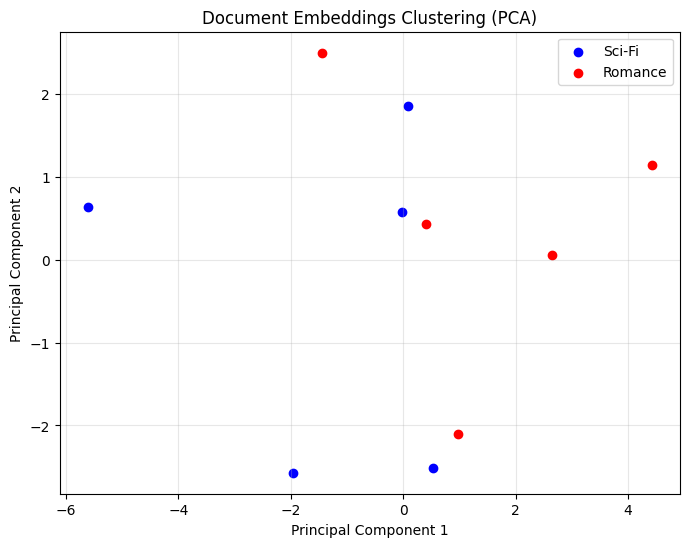

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# 1. Define sample documents representing distinct topics
sci_fi_docs = [
    "A futuristic robot fights to save the galaxy from alien invaders.",
    "Space explorers discover a new planet with mysterious life forms.",
    "In the year 3000, artificial intelligence controls the world.",
    "A time traveler tries to prevent a nuclear war in the future.",
    "The spaceship crew encounters a black hole during their mission."
]

romance_docs = [
    "A young couple falls in love during a summer vacation in Paris.",
    "She met her soulmate at a coffee shop on a rainy day.",
    "A romantic wedding ceremony takes place on a beautiful beach.",
    "Two high school sweethearts reunite after twenty years apart.",
    "He realized he was in love with his best friend all along."
]

all_docs = sci_fi_docs + romance_docs
labels = ["Sci-Fi"] * len(sci_fi_docs) + ["Romance"] * len(romance_docs)

# 2. Extract embeddings
embeddings = []
for doc in all_docs:
    # get_embedding returns shape (1, d_model), take [0] to get (d_model,)
    emb = get_semantic_embedding(doc, model)
    embeddings.append(emb[0])

X = np.array(embeddings)

# 3. Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 4. Plot
plt.figure(figsize=(8, 6))
unique_labels = list(set(labels))
colors = ['blue', 'red']

for i, label in enumerate(unique_labels):
    indices = [j for j, x in enumerate(labels) if x == label]
    plt.scatter(X_pca[indices, 0], X_pca[indices, 1], c=colors[i], label=label)

plt.title("Document Embeddings Clustering (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()